In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

2024-07-20 15:04:24.910323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 15:04:24.944293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 15:04:24.944331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 15:04:24.961989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 15:04:26.297692: W tensorflow/compiler/tf

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


### Load the data

In [3]:
# load the data
def load_pickle(file_name):
    return pd.read_pickle(file_name + '.pkl')

In [4]:
file_name = 'final_df'
df = load_pickle(data_directory + '/' + file_name)

In [5]:
# apply the function to the dataframe
df['keypoints'] = df['keypoints'].apply(lambda x: np.array(x))
df['object'] = df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
df['obj_vector'] = df['obj_vector'].apply(lambda x: np.array(x))
df['category'] = df['category'].apply(lambda x: np.array(x))

In [6]:
df['obj_input'] = df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
df['keypoints'] = df['keypoints'].apply(lambda x: x.flatten())

In [7]:
df

,filename,label,category,keypoints,object,obj_label,obj_vector,obj_words,obj_input
0,Image_1.jpg,sitting,11,"[0.06167532131075859, 0.508802056312561, 0.308...","[[0.60480165], [0.04718776], [0.032203343], [0...","[697, 789, 822, 514, 614]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [shoji], [steel, drum], [cowboy, bo...","[-0.20592125285495, 0.3260203410991888, -0.008..."
1,Image_2.jpg,using_laptop,14,"[0.2107752561569214, 0.995250403881073, 0.7055...","[[0.7418762], [0.040941585], [0.012892539], [0...","[831, 416, 669, 697, 681]","[[0.3403800129890442, -0.9357600212097168, 1.1...","[[studio, couch], [balance, beam], [mosquito, ...","[0.2683790374652541, -0.6670002713657828, 0.87..."
2,Image_3.jpg,hugging,7,"[0.09106554090976715, 0.47515493631362915, 0.5...","[[0.1416007], [0.13604547], [0.05453948], [0.0...","[697, 522, 984, 529, 416]","[[-0.28338998556137085, 0.4774399995803833, 0....","[[pajama], [croquet, ball], [rapeseed], [diape...","[-0.02030288063444885, 0.23200371996866265, 0...."
3,Image_4.jpg,sleeping,12,"[0.270770400762558, 0.4170025885105133, 0.3047...","[[0.6505104], [0.06191667], [0.027490702], [0....","[678, 691, 680, 529, 823]","[[-1.2170699834823608, -0.12339100241661072, -...","[[neck, brace], [oxygen, mask], [nipple], [dia...","[-0.8215984234954313, -0.02994576481942718, -0..."
4,Image_5.jpg,using_laptop,14,"[0.02712862566113472, 0.23545874655246735, 0.7...","[[0.71057284], [0.10088889], [0.035408325], [0...","[490, 655, 689, 824, 601]","[[-0.1615300178527832, -0.205020010471344, -0....","[[chain, mail], [miniskirt], [overskirt], [sto...","[-0.1494515264241883, -0.1284101833971808, -0...."
...,...,...,...,...,...,...,...,...,...
12595,Image_12596.jpg,sitting,11,"[0.023519866168498993, 0.40524551272392273, 0....","[[0.23895389], [0.14317973], [0.076097175], [0...","[706, 905, 624, 559, 831]","[[-0.399260014295578, 0.13120000064373016, -0....","[[patio], [window, shade], [library], [folding...","[-0.14739882579379793, 0.2794763101199509, -0...."
12596,Image_12597.jpg,clapping,1,"[0.035674747079610825, 0.25097161531448364, 0....","[[0.8603377], [0.021510318], [0.016789775], [0...","[617, 823, 678, 904, 905]","[[0.10435998439788818, 0.29162999987602234, 0....","[[lab, coat], [stethoscope], [neck, brace], [w...","[0.057619909586660134, 0.26067134955875726, 0...."
12597,Image_12598.jpg,sitting,11,"[0.045870888978242874, 0.51141756772995, 0.524...","[[0.48068434], [0.07919033], [0.043129846], [0...","[608, 743, 843, 487, 543]","[[-0.13323000073432922, -0.6275100111961365, -...","[[jean], [prison], [swing], [cellular, telepho...","[-0.001942008389194727, -0.2787240437545768, -..."
12598,Image_12599.jpg,dancing,3,"[0.2243669480085373, 0.4571295976638794, 0.596...","[[0.15199172], [0.068358354], [0.059058633], [...","[416, 615, 747, 617, 587]","[[0.5044400095939636, 0.536300003528595, -0.07...","[[balance, beam], [knee, pad], [punching, bag]...","[0.014005273690095521, 0.06621338508228547, -0..."


### Training-Validation split

In [8]:
def train_test_split(df, train_perc, seed):
    
    shuffled_df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    tr_samples = int(len(df)*train_perc)
    
    train_df = shuffled_df.iloc[:tr_samples]
    
    test_df = shuffled_df.iloc[tr_samples:]
    
    return [train_df,test_df]

In [9]:
def create_dataset(df, batch_size , shuffle=False, use_object=False, dataset_repeat=True):
    
    labels = df['category']
    
    kpoints = df['keypoints']

    # merge the two arrays
    if use_object:
        df['input'] = df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
    else:
        df['input'] = df['keypoints']

    if use_object:
        data = np.zeros((len(kpoints), 17*3+100))
    else:    
        data = np.zeros((len(kpoints), 17*3))
    
    for i, row in enumerate(df['input']): 
        data[i,:] = np.array(row)
        
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    
    if shuffle:
        dataset = dataset.shuffle(len(data))

    if dataset_repeat:        
        dataset = dataset.repeat()
    
    dataset = dataset.batch(batch_size = batch_size)
    
    return dataset

In [10]:
train_perc = 0.75
train, val = train_test_split(df = df, train_perc = train_perc, seed = 42)

In [11]:
batch_s = 32
use_object = True

dataset_train = create_dataset(train, batch_s, shuffle=False, use_object=use_object)
train_steps = int(np.ceil(len(train)/batch_s))

dataset_val = create_dataset(val, batch_s, shuffle=False, use_object=use_object)
val_steps = int(np.ceil(len(val)/batch_s))

### Define the model

In [12]:
if use_object:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(17*3+100,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(15, activation='softmax')
    ])
else:
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(17*3,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(15, activation='softmax')
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,503 (138.68 KB)

 Trainable params: 35,503 (138.68 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

results = model.fit(dataset_train,
                     epochs=1000,
                       steps_per_epoch=train_steps, 
                       validation_data=dataset_val, 
                       validation_steps=val_steps,
                        callbacks=[early_stop_callback])

Epoch 1/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2022 - loss: 2.4216 - val_accuracy: 0.4410 - val_loss: 1.7940
Epoch 2/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4207 - loss: 1.7807 - val_accuracy: 0.4634 - val_loss: 1.6940
Epoch 3/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4559 - loss: 1.6716 - val_accuracy: 0.4735 - val_loss: 1.6385
Epoch 4/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4709 - loss: 1.6140 - val_accuracy: 0.4836 - val_loss: 1.6062
Epoch 5/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4817 - loss: 1.5793 - val_accuracy: 0.4984 - val_loss: 1.5870
Epoch 6/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4995 - loss: 1.5428 - val_accuracy: 0.5035 - val_loss: 1.5615
Epoch 7/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4978 - loss: 1.5176 - val_accuracy: 0.5054 - val_loss: 1.5623
Epoch 8/1000
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5093 - loss: 1.4862 - 

In [14]:
# save the model
model.save(root_directory + 'models/lightning_mobilenet_17_3_100.keras')

### Analyze the results

In [15]:
train_loss = results.history['loss']

val_loss = results.history['val_loss']

train_accuracy = results.history['accuracy']

val_accuracy = results.history['val_accuracy']

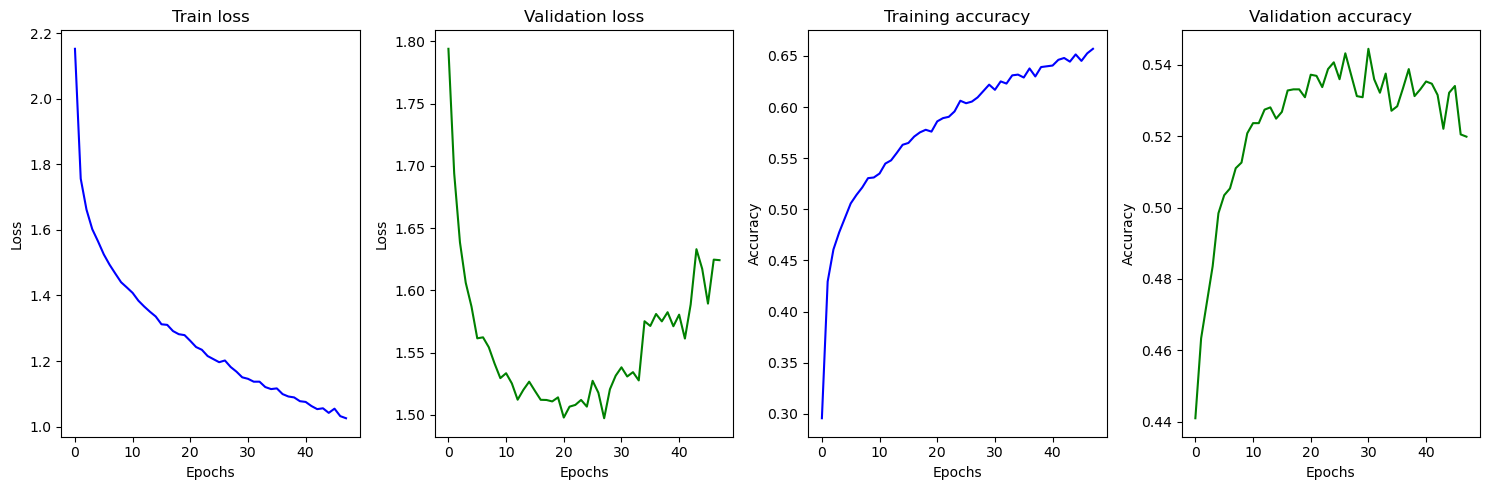

In [16]:
t = np.arange(len(train_accuracy))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.plot(t, train_loss, 'b')
ax1.set_title('Train loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2.plot(t, val_loss, 'g')
ax2.set_title('Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')

ax3.plot(t, train_accuracy, 'b')
ax3.set_title('Training accuracy')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Accuracy')

ax4.plot(t, val_accuracy, 'g')
ax4.set_title('Validation accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

### Results on the Validation set

In [24]:
# get the label from the category
labels = df.groupby('category').first()['label']
labels = np.array(labels).tolist()
labels[9] = 'music'

In [25]:
# predict on the validation set
dataset_val = create_dataset(val, batch_s, shuffle=False, use_object=use_object, dataset_repeat=False)

y_pred = model.predict(dataset_val)
pred = np.argmax(y_pred, axis=1)

# confusion matrix
from sklearn.metrics import confusion_matrix

y_true = val['category']

conf_matrix = confusion_matrix(y_true, pred)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


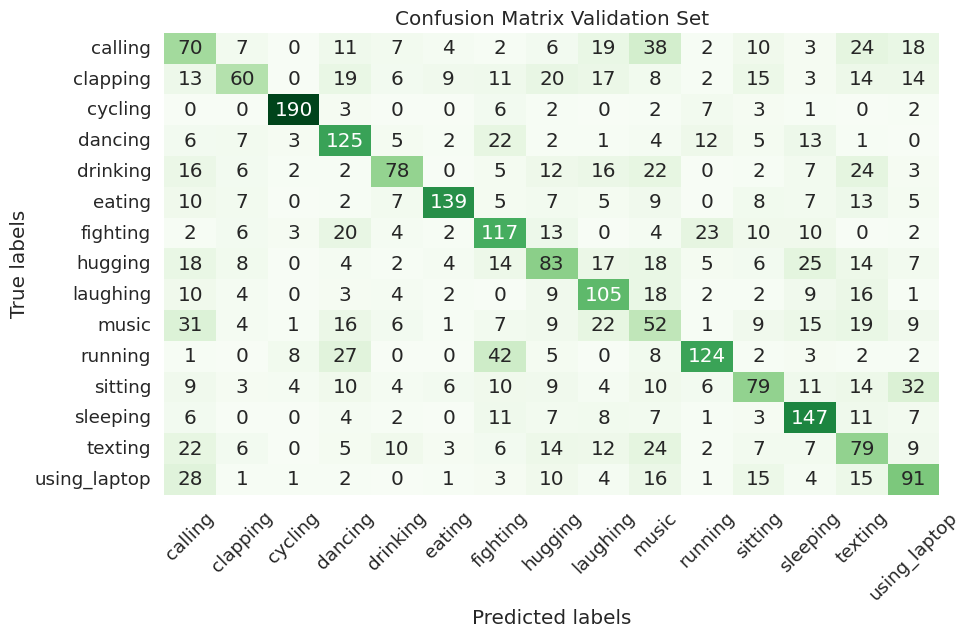

In [26]:
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.set(font_scale=1.2)  # Adjust font size

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Greens", cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.xticks(rotation=45)

plt.xlabel('Predicted labels')

plt.ylabel('True labels')

plt.title('Confusion Matrix Validation Set')

plt.show()

In [ ]:
def class_specific_metrics(cm, class_labels = [i for i in range(15)]):
    # Compute the confusion matrix

    # Initialize dictionaries to hold metrics for each class
    accuracy = {}
    sensitivity = {}
    specificity = {}
    precision = {}

    for idx, label in enumerate(class_labels):
        # True positives
        TP = cm[idx, idx]

        # False positives
        FP = cm[:, idx].sum() - TP

        # False negatives
        FN = cm[idx, :].sum() - TP

        # True negatives
        TN = cm.sum() - (TP + FP + FN)

        # Calculate metrics
        accuracy[label] = (TP + TN) / cm.sum()
        sensitivity[label] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[label] = TN / (TN + FP) if (TN + FP) != 0 else 0
        precision[label] = TP / (TP + FP) if (TP + FP) != 0 else 0

    metrics_dict = {label: {'Accuracy': accuracy[label],
                        'Sensitivity': sensitivity[label],
                        'Specificity': specificity[label],
                        'Precision': precision[label]}
                    for label in class_labels}

    # Convert the dictionary to a pandas DataFrame
    df_metrics = pd.DataFrame.from_dict(metrics_dict, orient='index')
    df_metrics

    return df_metrics

In [ ]:
val_metrics = class_specific_metrics(conf_matrix)
val_metrics

,Accuracy,Sensitivity,Specificity,Precision
0,0.920952,0.384615,0.961420,0.429293
1,0.940317,0.417062,0.977884,0.575163
2,0.987302,0.902778,0.993524,0.911215
3,0.943810,0.625000,0.966349,0.567686
4,0.942222,0.502564,0.971235,0.535519
5,0.969841,0.741071,0.987355,0.817734
6,0.930159,0.643519,0.951261,0.492908
7,0.923810,0.444444,0.960684,0.465116
8,0.938730,0.556757,0.962563,0.481308
9,0.906984,0.336634,0.946065,0.299559


### Prediction on the training set


In [ ]:
# predict on the training set
dataset_train = create_dataset(train, batch_s, shuffle=False, use_object=use_object, dataset_repeat=False)
y_pred_train = model.predict(dataset_train, steps=train_steps)

pred_train = np.argmax(y_pred_train, axis=1)

# confusion matrix
y_true_train = train['category']

conf_matrix_train = confusion_matrix(y_true_train, pred_train)

296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


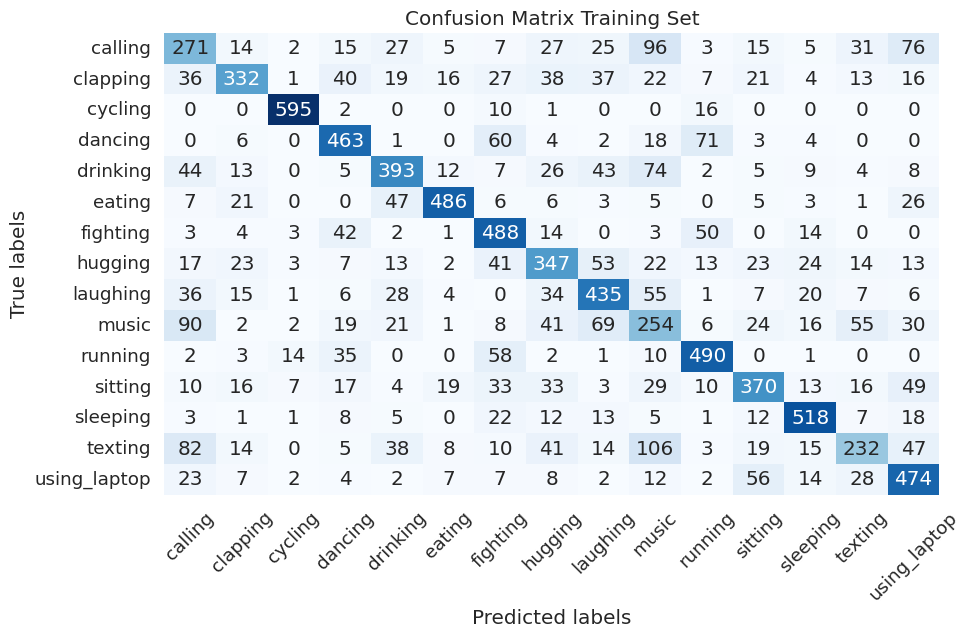

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.set(font_scale=1.2)  # Adjust font size

sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=labels, yticklabels=labels)

plt.xticks(rotation=45)

plt.xlabel('Predicted labels')

plt.ylabel('True labels')

plt.title('Confusion Matrix Training Set')

plt.show()

In [ ]:
train_metrics = class_specific_metrics(conf_matrix_train)
train_metrics

,Accuracy,Sensitivity,Specificity,Precision
0,0.925820,0.437803,0.960027,0.434295
1,0.953862,0.527822,0.984242,0.704883
2,0.993122,0.953526,0.995921,0.942948
3,0.960423,0.732595,0.976752,0.693114
4,0.951429,0.609302,0.976491,0.655000
5,0.978307,0.788961,0.991510,0.866310
6,0.954286,0.782051,0.966463,0.622449
7,0.941270,0.564228,0.967516,0.547319
8,0.948677,0.664122,0.969869,0.621429
9,0.911005,0.398119,0.948139,0.357243


### Testing set

In [ ]:
test_df = load_pickle(data_directory + '/test_df')

In [ ]:
test_df

,filename,keypoints,object,obj_label,obj_vector,obj_words
0,Image_1.jpg,"[0.07926996797323227, 0.5947930812835693, 0.56...","[0.2516569, 0.17761408, 0.04274578, 0.04146244...","[435, 876, 434, 747, 797]","[[0.41319000720977783, 0.052032001316547394, 0...","[[bathtub], [tub], [bath, towel], [punching, b..."
1,Image_2.jpg,"[0.0785704255104065, 0.43337151408195496, 0.58...","[0.22382939, 0.107774235, 0.08901217, 0.037059...","[762, 860, 726, 526, 415]","[[0.2788099944591522, -0.4242599904537201, -0....","[[restaurant], [tobacco, shop], [plane], [desk..."
2,Image_3.jpg,"[0.026546861976385117, 0.9105532765388489, 0.2...","[0.6181695, 0.08971589, 0.019042958, 0.0186859...","[974, 562, 980, 972, 862]","[[0.019871000200510025, 0.7510499954223633, -0...","[[geyser], [fountain], [volcano], [cliff], [to..."
3,Image_4.jpg,"[0.05568854138255119, 0.6325057744979858, 0.39...","[0.25478286, 0.08816597, 0.042543884, 0.038421...","[865, 399, 911, 917, 400]","[[0.5181999802589417, -0.48190000653266907, -0...","[[toyshop], [abaya], [wool], [comic, book], [a..."
4,Image_5.jpg,"[0.06054305285215378, 0.6548119187355042, 0.77...","[0.06376454, 0.05839194, 0.04397597, 0.0288917...","[465, 841, 590, 419, 681]","[[-1.02715003490448, -0.5592600107192993, -0.1...","[[bulletproof, vest], [sweatshirt], [hand, hel..."
...,...,...,...,...,...,...
5395,Image_5396.jpg,"[0.09091931581497192, 0.43842214345932007, 0.4...","[0.13928552, 0.076878965, 0.073724136, 0.06629...","[459, 638, 400, 911, 903]","[[1.0575000047683716, 1.347100019454956, 0.264...","[[brassiere], [maillot], [academic, gown], [wo..."
5396,Image_5397.jpg,"[0.05253060534596443, 0.9547996520996094, 0.27...","[0.17326465, 0.09512971, 0.034398936, 0.028374...","[525, 580, 807, 428, 842]","[[0.3268199861049652, -0.34040001034736633, -0...","[[dam], [greenhouse], [solar, dish], [barrow],..."
5397,Image_5398.jpg,"[0.030637364834547043, 0.6961045861244202, 0.4...","[0.2768016, 0.091625154, 0.07929682, 0.051239,...","[981, 921, 862, 781, 851]","[[0.7649499773979187, 0.6759799718856812, 0.68...","[[ballplayer], [book, jacket], [torch], [score..."
5398,Image_5399.jpg,"[0.06117207556962967, 0.32603949308395386, 0.5...","[0.29293764, 0.1566693, 0.032930996, 0.0255190...","[703, 608, 487, 414, 765]","[[0.6208399534225464, 0.5554400086402893, 0.94...","[[park, bench], [jean], [cellular, telephone],..."


In [ ]:
test_df['keypoints'] = test_df['keypoints'].apply(lambda x: np.array(x).flatten())  
test_df['object'] = test_df['object'].apply(lambda x: np.array(x).reshape(-1, 1))
test_df['obj_vector'] = test_df['obj_vector'].apply(lambda x: np.array(x))

test_df['obj_input'] = test_df.apply(lambda x: np.sum(x['object']*x['obj_vector'], axis=0), axis=1)
test_df['keypoints'] = test_df['keypoints'].apply(lambda x: x.flatten())

if use_object:
    test_df['input'] = test_df.apply(lambda x: np.concatenate((x['keypoints'], x['obj_input'])), axis=1)
else:
    test_df['input'] = test_df['keypoints']                                                

NameError: name 'use_object' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted class: cycling


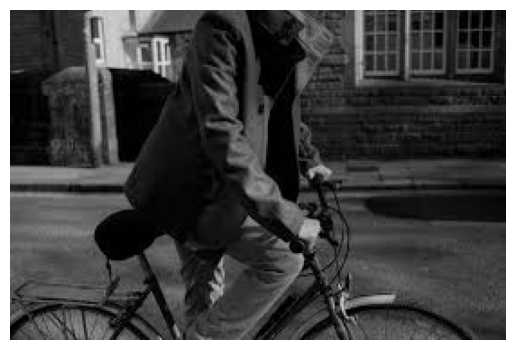

In [ ]:
# choose a random image and predict
image = test_df.sample(1)

input = image['input'].values[0].reshape(1, -1)

y_pred = model.predict(input)

pred = np.argmax(y_pred)

print('Predicted class: ' + labels[pred])

image_path = data_directory + '/test/' + image['filename'].values[0]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()